# Route Algorithm Parameter Optimization

In the current version (Sept 2020) of our routing algorithm, there are a couple of parameters that we have manually set, mostly on empirical trial, but rather arbitrary, tests. The aim of this notebook is try to find a set of parameters that optimizes the result of the algorithm, but based on the statistical analysis of data and not on empiric approaches. To do so, we have collected data on the calculation of about 8000 routes, where a grid of algorithm parameters where tested for different set of autos, plug configuration and route lengths, hence, generalizing as much the results.

After analyzing the route data, we have checked the effect of the studied parameters on the resulting calculated routes and, based on these, choose the best set that yields, in average, the best route results in terms of total charge time, number of stops and optimization time.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Parameters" data-toc-modified-id="Parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Overhead" data-toc-modified-id="Overhead-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Overhead</a></span></li><li><span><a href="#Relative-MIP-Gap" data-toc-modified-id="Relative-MIP-Gap-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Relative MIP Gap</a></span></li></ul></li><li><span><a href="#Strategy" data-toc-modified-id="Strategy-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Strategy</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Correlations" data-toc-modified-id="Correlations-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Correlations</a></span></li><li><span><a href="#Parameter-selection" data-toc-modified-id="Parameter-selection-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Parameter selection</a></span></li></ul></li><li><span><a href="#Multithreading" data-toc-modified-id="Multithreading-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Multithreading</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

## Parameters

The algorithm parameters to be optimized are the overhead and the relative Mixed Integer Programming gap.

### Overhead

Overhead, is a parameter that acts like a penalty or a cost that needs to be paid for each charging stop the EV does along the route. Hence, this parameter allows to control the amount of stops the EV does along the route. A small overhead yields route solutions that have many stops with short charging times, whereas a large overhead value generates solution routes with few stops but with large charging times. Therefore, a fine tuning of this parameter is important in order to get solution with optimized number of charging stops and charging times.

### Relative MIP Gap

For large integer programming models like ours, to find a global, proven optimal solution might take a really long time. A straightforward way to deal with this is to set a time limit. Another way is to set a gap tolerance limit on the relative gap between the best possible or upper bound (UB) and the best found integer solution or lower bound (LB). For details and examples on how the Branch and Bound algorithm works to find optimal solutions of Mixed Integer Linear Programming (MILP) problems, please refer to this [link](http://web.tecnico.ulisboa.pt/mcasquilho/compute/_linpro/TaylorB_module_c.pdf).

The relative gap is defined as:

$$
Gap = \frac{UB-LB}{LB}
$$

In our current implementation of the Routing Algorithm we have a time limit of 30 seconds and a relative gap tolerance limit of 0.2. Thus, the optimization process will stop once one of these limits is hit.

## Strategy

In order to find the best set of parameters that optimizes the routing algorithm we have run the following experiment.

We have chosen five different Electric Vehicles (EV) and run the routing algorithm for the 20 different routes  shown in the matrix below. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

cities = ['Berlin','Dresden','Hamburg','München','Köln']

print('Route matrix used for the algorithm test.')
pd.DataFrame([['{}-{}'.format(origin, destination) if origin!=destination else '' for destination in cities ] 
              for origin in cities ], columns=cities, index= cities)

Route matrix used for the algorithm test.


Berlin          Dresden          Hamburg          München  \
Berlin                    Berlin-Dresden   Berlin-Hamburg   Berlin-München   
Dresden  Dresden-Berlin                   Dresden-Hamburg  Dresden-München   
Hamburg  Hamburg-Berlin  Hamburg-Dresden                   Hamburg-München   
München  München-Berlin  München-Dresden  München-Hamburg                    
Köln        Köln-Berlin     Köln-Dresden     Köln-Hamburg     Köln-München   

                 Köln  
Berlin    Berlin-Köln  
Dresden  Dresden-Köln  
Hamburg  Hamburg-Köln  
München  München-Köln  
Köln

The chosen EVs were a Tesla Model S 75D, Tesla Model 3, Hyundai Ioniq Elektro, Nissan Leaf 40kWh and a VW e-Golf. These EVs have different battery capacities ranging from 100 kWh down to 28 kWh. They also have different plug configurations, thus allowing us to test route solutions for cases where different plugs are requested, e.g.,  CCS, CHAdeMO, Type 2 and Tesla superchargers. Regarding the Teslas, we have chosen these two models since they have different constraints given their plug configuration. For instance the Model S 75D can only use Type 2 Chargers and Tesla Supercharges (TS), whereas the Model 3, is not restricted to only TS but can access also CCS plugs from other providers. 

The route algorithm was run assuming that the EV departs the Origin city with a 50% State of Charge (SoC) and should arrive charging stations and the Destination city with not less that 10% SoC.

This combination of routes and EV provides us with a broad variety of conditions to test the algorithm ensuring that we try almost all possible scenarios. Another important thing to mention is that a given route can have a large amount of charging stations that can be used during the route optimization, however, in order to facilitate and speed up the solution time during the optimization we have limited the amount of stations to be a number *nr_stations* (currently equal to 70). The selection of the *nr_stations* from the total set of stations is done randomly using a weighting factor proportional to the charging power of the column. In this way, columns with large charging power are more likely to be picked up during the sampling. Now, for our current experiment in order to have comparable conditions it is important that for the same route, we have exactly the same set of charging columns. To ensure this, we have set the random seed of the sampling to a value of 42. Why 42? Because as everyone knows, 42 is the answer to life, the universe and everything.  

Finally, for each combination of EV and Route, the routing algorithm was run for different sets of overhead and gap limit parameters. The overhead parameter, for instance, was varied from 5 to 100 in steps of 5 for gap limit values of 0.1, 0.15 and 0.2. This yields a total amount of 6000 calculated routes, thus providing us with enough statistics to find an optimal set of algorithm parameters.

## Results

For each calculated route we have collected the following information:

+ Drive time
+ Charge time
+ Total Route time = Drive time + Charge Time
+ Total drive distance 
+ Number of charging stops
+ Total Optimization time
+ Objective function value
+ Relative gap

In order to properly compare and analyze this data we need to normalize some of the collected metrics. The normalization is done as follows:

First we subset the data into routes calculated with a gap limit = 0.1, 0.15 and 0.2. For each of these subsets we have once more, made a subset where only data for a given EV-Route combination is selected. Lets take for example the subset Nissan Leaf/Hamburg-Dresden. In this example, the subset consists of the Nissan Leaf route Hamburg-Dresden calculated 20 times, one for each overhead value between 5 and 100 in steps of 5.  

For the drive, charge and total route times we have normalize their values with their minimum among the 20 calculated routes. Since we aim to minimize the time, the closest to 1 the normalized value is, the better.

On the other hand, the number of charging stops was normalized with respect to the largest value obtained in the subset, hence, the smallest the normalized number of stops is, the less stops the EV does along the route.

Below in Fig. 1 is an example of the normalized values of the  routes Hamburg-Dresden and Hamburg-München with the Nissan Leaf.

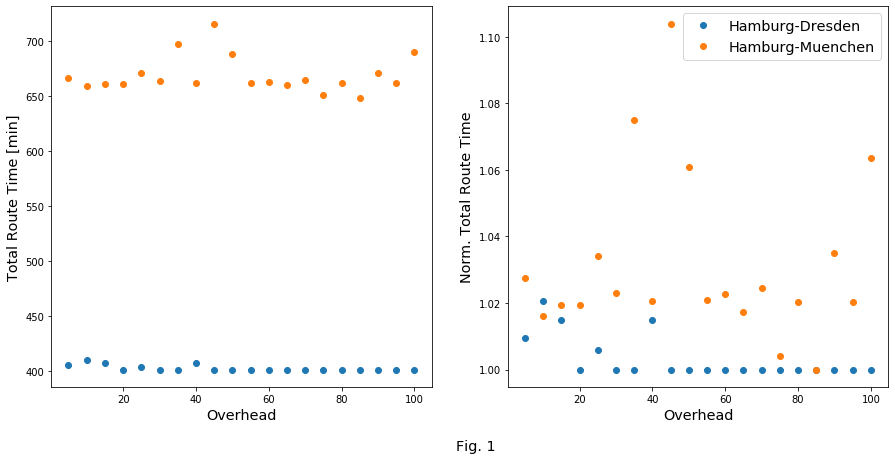

In [2]:
def normalize(df):
    norm_data = pd.DataFrame()

    for auto in df.auto.unique():
        for route in df.route.unique():
            mask = (df.route == route) & (df.auto==auto)
            masked = df[mask].copy()
            masked['norm_stops'] = masked.stops/masked.stops.max()
            masked['norm_chargetime'] = masked.charge_time/masked.charge_time.min()
            masked['norm_drivetime'] = masked.drive_time/masked.drive_time.min()
            masked['norm_totaltime'] = masked.total_time/masked.total_time.min()
            norm_data = norm_data.append(masked, ignore_index=False)
    return norm_data

# load data
gap02_data = pd.read_csv('overhead_test.csv')
gap01_data = pd.read_csv('overhead_test_gap_01.csv')
gap015_data = pd.read_csv('overhead_test_gap_015.csv')

#normalize data
gap02_data = normalize(gap02_data)
gap01_data = normalize(gap01_data)    
gap015_data = normalize(gap015_data)    

fig, axs = plt.subplots(1,2, figsize=(15,7))
route = 'Hamburg-Dresden'
mask = (gap02_data.route == route) & (gap02_data.auto=='Leaf 40kWh')
axs[0].plot(gap02_data[mask].overhead, gap02_data[mask].total_time, 'o', label=route)
axs[1].plot(gap02_data[mask].overhead, gap02_data[mask].norm_totaltime, 'o', label=route)

route = 'Hamburg-Muenchen'
mask = (gap02_data.route == route) & (gap02_data.auto=='Leaf 40kWh')
axs[0].plot(gap02_data[mask].overhead, gap02_data[mask].total_time, 'o', label=route)
axs[1].plot(gap02_data[mask].overhead, gap02_data[mask].norm_totaltime, 'o', label=route)

axs[0].set_ylabel('Total Route Time [min]', fontsize='x-large')    
axs[0].set_xlabel('Overhead', fontsize='x-large')    
axs[1].set_ylabel('Norm. Total Route Time', fontsize='x-large')    
axs[1].set_xlabel('Overhead', fontsize='x-large')    
axs[1].legend(fontsize='x-large')    
fig.text(0.5,0,'Fig. 1', fontsize='x-large')
fig.tight_layout;

The plot at the left in Fig.1 shows the resulting Total route time of the routes Hamburg-Dresden (blue) and Hamburg-München (orange) in minutes. As observed, comparison between the two is difficult since the travel time for these routes is too different. The right plot shows the normalized time obtained by diving by the minimum value of the route subset. Here the subsets can now be compared.

Figure 2 below, shows the normalized charge and drive times, the normalized number of charge stops and the optimization time for all the routes and all the EVs calculated using a gap limit of 0.2. As can be seen they are properly scaled and normalized so they can be compared.

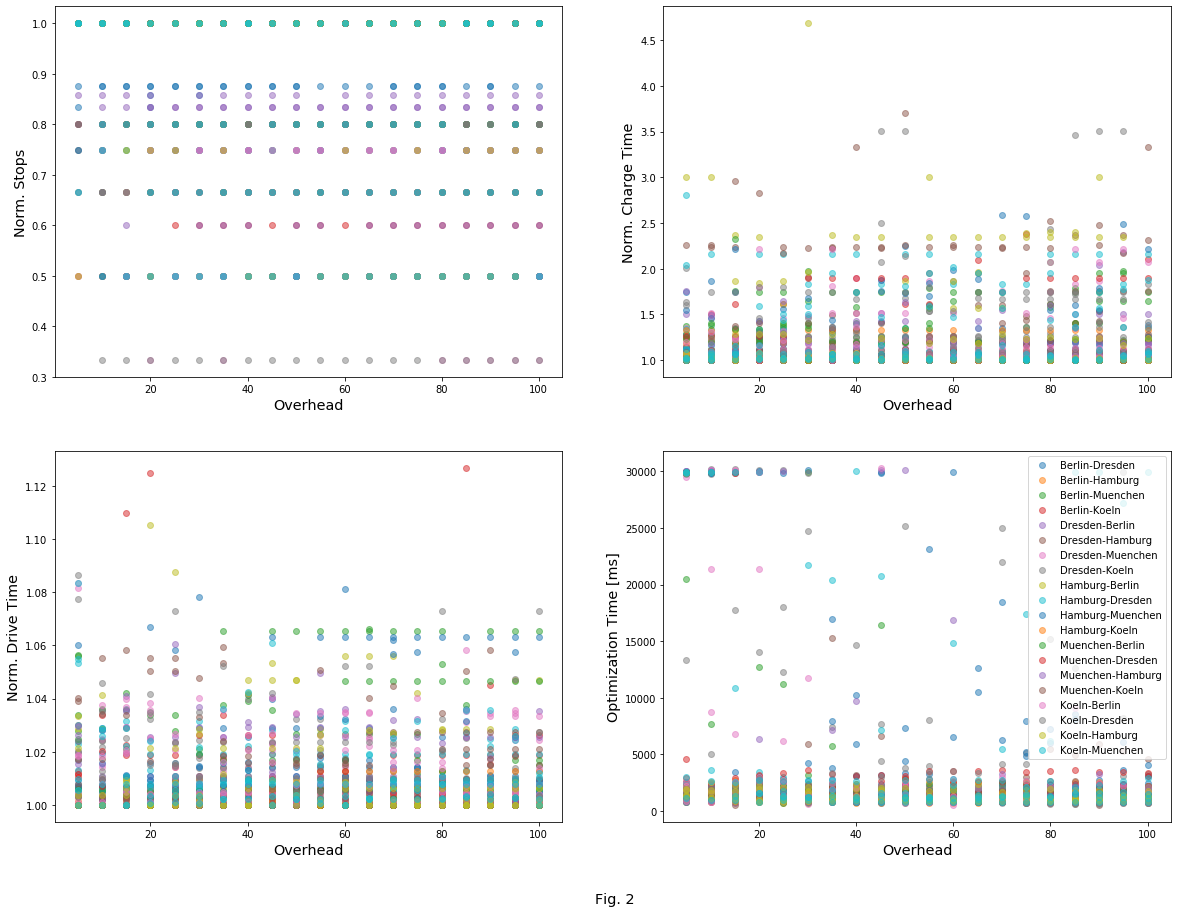

In [3]:
fig, axs = plt.subplots(2,2, figsize=(20,15))
for route in gap02_data.route.unique():
    mask = (gap02_data.route == route)
    axs[0,0].plot(gap02_data[mask].overhead, gap02_data[mask].norm_stops, 'o', alpha=0.5, label=route)
    axs[0,0].set_ylabel('Norm. Stops',fontsize='x-large')    
    axs[0,0].set_xlabel('Overhead',fontsize='x-large')    
    
    axs[0,1].plot(gap02_data[mask].overhead, gap02_data[mask].norm_chargetime, 'o', alpha=0.5, label=route)
    axs[0,1].set_ylabel('Norm. Charge Time',fontsize='x-large')    
    axs[0,1].set_xlabel('Overhead',fontsize='x-large')   

    axs[1,0].plot(gap02_data[mask].overhead, gap02_data[mask].norm_drivetime, 'o',  alpha=0.5, label=route)
    axs[1,0].set_ylabel('Norm. Drive Time',fontsize='x-large')   
    axs[1,0].set_xlabel('Overhead',fontsize='x-large')   

    axs[1,1].plot(gap02_data[mask].overhead, gap02_data[mask]['wall time'], 'o',  alpha=0.5, label=route)
    axs[1,1].set_ylabel('Optimization Time [ms]',fontsize='x-large')   
    axs[1,1].set_xlabel('Overhead',fontsize='x-large')   
    axs[1,1].legend()    

fig.text(0.5,0.05,'Fig. 2', fontsize='x-large')
fig.tight_layout;

The next step is to group all the collected data for a given overhead value and find their mean values. Lets take as an example the lower right plot in Fig. 2 (optimization time) and select the data corresponding to overhead = 20 and 50.

Fig. 3 below, shows the histogram of the optimization time for these two overheads, together with a summary of statistics like number of points (count), max and min values, mean, standard deviations and the 25, 50 and 75 quantiles.

Table 1: Statistics Summary Overhead: 20 and 50, Gap limit:0.2


20            50
count    100.000000    100.000000
mean    3846.060000   2121.000000
std     7154.205634   3793.823066
min      822.000000    679.000000
25%     1144.000000   1030.750000
50%     1561.000000   1354.000000
75%     2379.750000   2016.000000
max    30135.000000  30123.000000

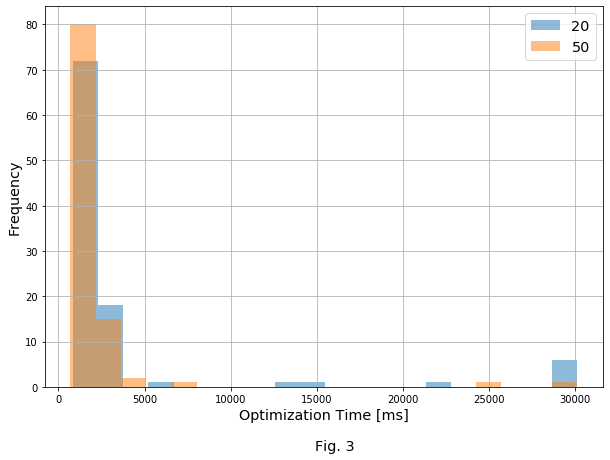

In [4]:
fig = plt.figure()
gap02_data[gap02_data.overhead==20]['wall time'].hist(bins=20,figsize=(10,7), alpha=0.5, label = '20')
gap02_data[gap02_data.overhead==50]['wall time'].hist(bins=20,figsize=(10,7), alpha=0.5, label = '50')
plt.xlabel('Optimization Time [ms]', fontsize='x-large')
plt.ylabel('Frequency', fontsize='x-large')
plt.legend(fontsize='x-large')
fig.text(0.5,0, 'Fig. 3', fontsize='x-large')
print('Table 1: Statistics Summary Overhead: 20 and 50, Gap limit:0.2')
_ = pd.concat([gap02_data[gap02_data.overhead==20]['wall time'].describe(),
               gap02_data[gap02_data.overhead==50]['wall time'].describe()], axis=1)
_.columns = ['20', '50']
_

For our purpose, we are interested in the mean value, so we collect all mean values for all the overheads and see if there is a trend that we can use to pick an optimal value for our routing algorithm.

### Correlations

Fig. 4 below, shows the plots of the resulting grouped data as a function of overhead for different relative gap values. The solid lines are fits to the data. All data was fitted using a linear approximation except for the normalized number of stops and the optimization time, which were fitted with a third order polynomial. These lines are mainly intended to serve as a guide to the eye. The vertical line at overhead = 40 delimits two regions that will be discussed next.

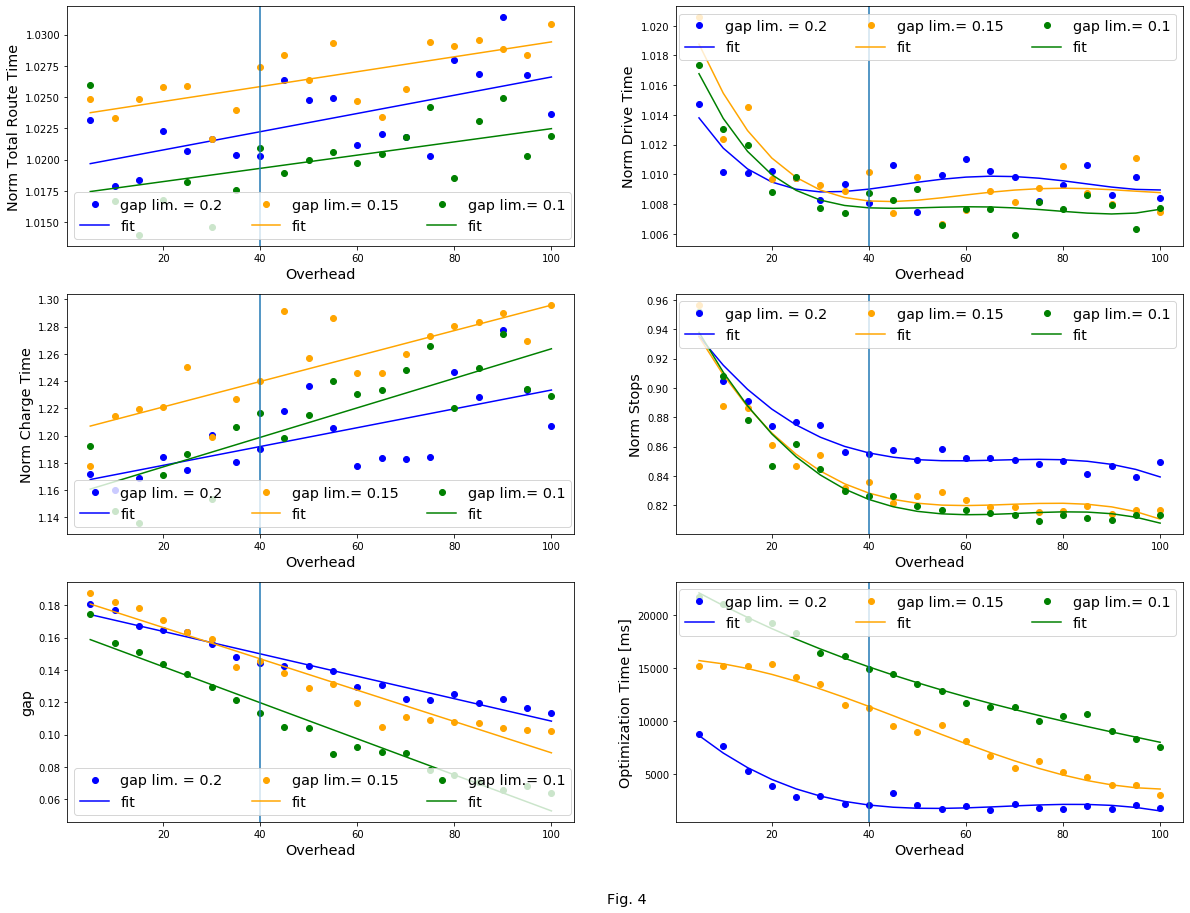

In [5]:
# group data by overhead
gap02_grouped = gap02_data.groupby('overhead').mean().reset_index()
gap01_grouped = gap01_data.groupby('overhead').mean().reset_index()
gap015_grouped = gap015_data.groupby('overhead').mean().reset_index()

def plot_col(col, i):
    col_fit02 = np.poly1d(np.polyfit(gap02_grouped.overhead,gap02_grouped[col], deg=degs[i]))
    col_fit015 = np.poly1d(np.polyfit(gap015_grouped.overhead,gap015_grouped[col], deg=degs[i]))
    col_fit01 = np.poly1d(np.polyfit(gap01_grouped.overhead,gap01_grouped[col], deg=degs[i]))

    ax1 = fig.add_subplot(3,2,i+1)
    ax1.plot(gap02_grouped.overhead,gap02_grouped[col], 'o', c='b',label='gap lim. = 0.2')
    ax1.plot(gap02_grouped.overhead,col_fit02(gap02_grouped.overhead),  c='b',label='fit')
    ax1.plot(gap015_grouped.overhead,gap015_grouped[col], 'o', c='orange', label='gap lim.= 0.15')
    ax1.plot(gap015_grouped.overhead,col_fit015(gap015_grouped.overhead), c='orange', label='fit')
    ax1.plot(gap01_grouped.overhead,gap01_grouped[col], 'o', c='green', label='gap lim.= 0.1')
    ax1.plot(gap01_grouped.overhead,col_fit01(gap01_grouped.overhead), c='green', label='fit')
    ax1.axvline(40)
    ax1.legend(fontsize='x-large', ncol=3)    
    ax1.set_ylabel(col_names[i],fontsize='x-large')    
    ax1.set_xlabel('Overhead',fontsize='x-large')   
    
cols = ['norm_totaltime', 'norm_drivetime','norm_chargetime', 'norm_stops', 'gap', 'wall time']
col_names = ['Norm Total Route Time', 'Norm Drive Time','Norm Charge Time', 'Norm Stops', 'gap', 'Optimization Time [ms]']

degs = [1,4,1,3,1,3]
fig = plt.figure(figsize=(20,15))
for i, col in enumerate(cols):
    plot_col(col, i)
fig.text(0.5,0.05,'Fig. 4', fontsize='x-large')
plt.tight_layout;   

In table 1 below, are the Pearson $r$ values for the parameters in Fig. 4 that show a linear relation together with their corresponding $p$ values. As a reminder, the Pearson's $r$ denotes the direction and the strength or linear correlation, whereas the $p$ values is a measurement of the statistical significance. If we set a significance threshold of 5%, then $p$ values larger than 0.05 are statistically insignificant and can not be used to draw conclusions on the data.

In [6]:
from scipy.stats import pearsonr

def getPval(df, params):
    """
    Calculates the Pearson r correlation coefficient and its p value to test if 
    there is a significance in the correlation
    """
    res = pd.DataFrame()
    for i, par in enumerate(params):
        r, p =pearsonr(df['overhead'],df[par])
        res = pd.concat([res, pd.DataFrame({'Parameters':['{} - {}'.format('overhead', par)],
                                            'r':[r.round(2)],
                                            'p': [p.round(2)]})], ignore_index=True)
    return res.set_index('Parameters')
    
params = ['norm_totaltime','norm_chargetime','gap']    
                            
pearson_01=getPval(gap01_grouped, params)
pearson_015=getPval(gap015_grouped, params)
pearson_02=getPval(gap02_grouped, params)

print('{:^40}'.format('Table 1: Pearnson r values and their corresponding p values.'))
_=pd.concat([pearson_01,pearson_015,pearson_02], keys=['gap lim: 0.1','gap lim: 0.15','gap lim: 0.2'], axis=1)
_

Table 1: Pearnson r values and their corresponding p values.


gap lim: 0.1       gap lim: 0.15      gap lim: 0.2  \
                                      r     p             r    p            r   
Parameters                                                                      
overhead - norm_totaltime          0.49  0.03          0.69  0.0         0.63   
overhead - norm_chargetime         0.82  0.00          0.82  0.0         0.67   
overhead - gap                    -0.98  0.00         -0.97  0.0        -0.98   

                                 
                              p  
Parameters                       
overhead - norm_totaltime   0.0  
overhead - norm_chargetime  0.0  
overhead - gap              0.0

As observed in Table 1, all $p$ values are significant.

Let start first discussing the normalized total route time/overhead (Fig. 4, Upper left) correlation. As observed there is a positive correlation which is moderate, as given by their $r$ values in Table 1. Positive correlation means that the larger the overhead value, the larger the norm. total route time is. 

Looking now at the overhead/Norm. charge time (Fig. 4, middle left), the correlation is positive and strong. So the larger the overhead, the larger the charge time is. This result is not surprising, since as we already discussed, when larger values of overhead are selected, this forces the algorithm to take fewer charging stops, but by doing this, stops will take longer. In contrast, smaller overhead values, allows the algorithm to do more stops with shorter charging times. This behavior is also reflected in the middle right plot in Fig. 4. Here we can see the normalized amount of charging stops as a function of overhead. So, for overhead values below the vertical line (overhead = 40), we see that the number of stops is large. Upon increasing overhead, the charging stops rapidly decrease and then, after overhead ~40 it stabilizes.

So as a first conclusion, we can say that routes calculated with overhead values above 40 tend to have less stops. 

Moving to the overhead/gap correlation (Fig. 4, lower left) we observe, that there is a very strong negative correlation, so the largest the overhead the smallest the final relative gap is. This means that with larger overhead values, the resulting calculated routes get closer to optimum values (i.e., gap=0), for the given parameter constraints. 
Note also that, for the routes where the gap is larger than the gap limit, this means that the time limit constraint was hit first during optimization, which also means that optimization took 30 seconds i.e., the maximum time allowed. 

Having a closer look to the lower left plot in Fig. 4, one can see that for gap limits of 0.15 and 0.1, and overhead values below ~40, the gap is larger than the gap limit. Which means that the calculation takes long time. This is not much the case for routes calculated using a gap limit of 0.2.
This can be better appreciated in the lower right plot in Fig. 4, where the optimization time is plotted against the overhead parameter. As observed for a gap limit of 0.2 the optimization time is much shorter than for the other two gap limits, moreover one can see that by increasing overhead, the time decreases and after an overhead value of 40, the optimization time stabilizes to about 2000 ms.  

As second conclusion we can say that for overhead values above 40, the optimization time and gap values are smaller, meaning that they are more time efficient and that their solutions are closer to optimal. This is specially true when the gap limit is 0.2.

### Parameter selection

To decide which parameters to take into our final algorithm we need to define some requirements that we consider the algorithm should have. For instance, for the routing service we expect that the algorithm delivers a reasonable route in the sense of moderate amount of charging stops (not too many, not too less) that brings the driver to its destination in the shortest possible time (total route time). It is also important that the time required to do this calculation (optimization time) is as short as possible.

Now, under this considerations and based on the data that we have here analyzed the best combination of parameters is an overhead value above 40, since in this regime the number of stops is small. However, the overhead must also not be too large so that the charging stops and consequently the total route time gets too long. Therefore a good overhead value is **50**. Regarding the gap limit, we definitively observe that a value of **0.2** yields a fast optimization time (~2 sec in average, see Fig. 4 lower right) and with better results in terms of the charging time as compared to the other gap limits (see Fig. 4, middle left).
One has to notice, however, that the amount of charging stops could be slightly enhanced for gap limit 0.2 as observed in the middle right plot of Fig. 4.

## Multithreading

Finally, there is another parameter that one can modify in order to potentially decrease the optimization time, this parameter is the number of parallel threads to run the optimization. To test the influence of multi-threading (MT) on the calculated routes we have run the algorithm once again using 8 threads for all combination of EVs and routes, however, this time we have set the overhead parameter to 50 and have varied the gap limit value from 0.05 to 0.2 in 0.025 steps. Note also that since when using multi-threading the calculation time is split into the number of threads, then the time limit imposed on the calculation is effectively shorter. In order to check the effect of time limit on the MT, we have done these calculations for two values of time limit namely, 30 and 60 seconds. This yields a total of 1400 calculated routes.

In Fig. 5 below are the plots of the calculated route data as a function of gap limit using time limits of 30 seconds (blue) and 60 seconds (orange). Table 2, shows the Pearson's $r$ linear correlation coefficients and their corresponding $p$ values.

Table 2: Pearson's r and their p values


Time lim: 30s       Time lim: 60s      
                                        r     p             r     p
Parameters                                                         
gap limit - norm_chargetime          0.97  0.00          0.99  0.00
gap limit - norm_drivetime           0.22  0.63         -0.26  0.57
gap limit - norm_totaltime           0.96  0.00          0.98  0.00
gap limit - gap                      0.98  0.00          0.99  0.00
gap limit - norm_stops               0.75  0.05         -0.85  0.02
gap limit - wall time               -0.99  0.00         -0.99  0.00

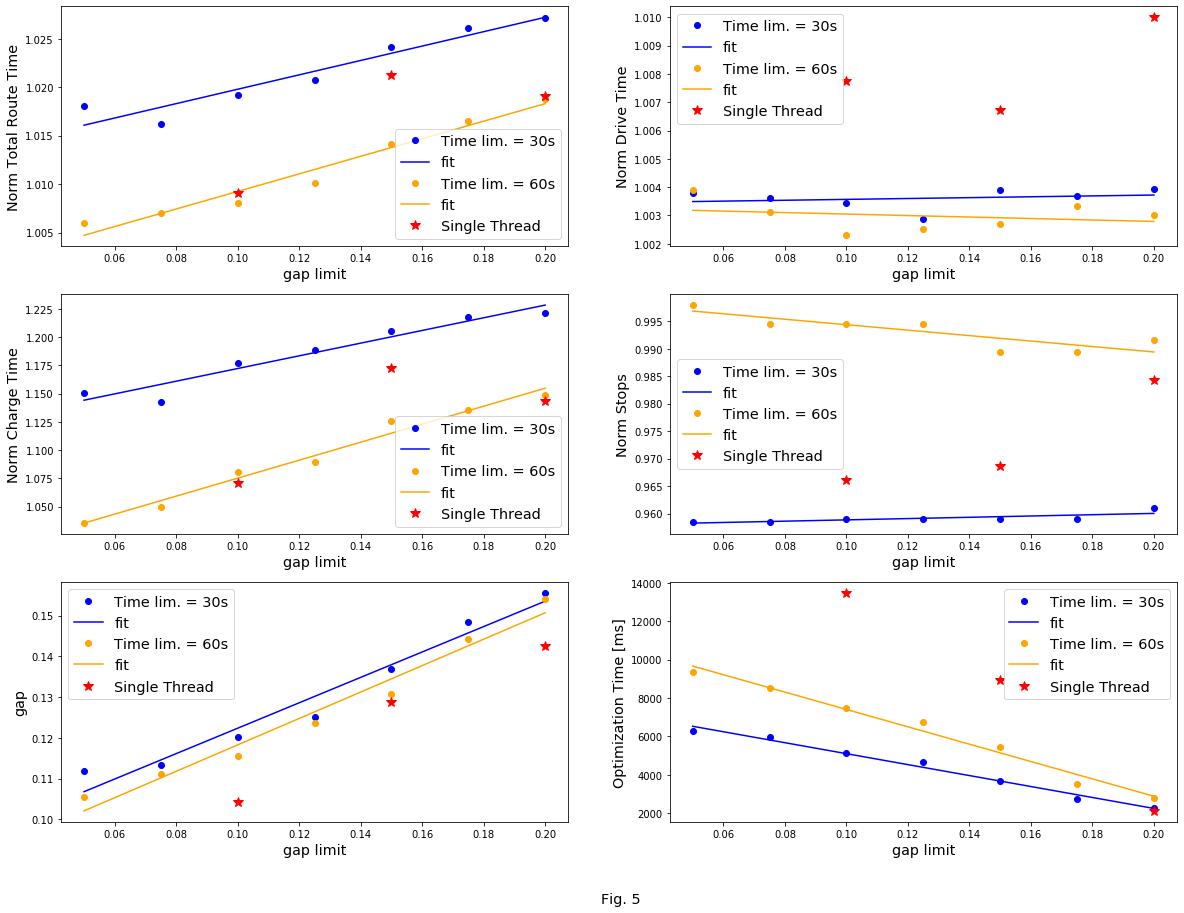

In [7]:
# load data
oh_50_data = pd.read_csv('overhead_test_multithread_oh_50.csv')
oh_50_60s_data = pd.read_csv('overhead_test_multithread_oh_50_60sec.csv')

# append single thread data with overhead=50
oh_50_data_full = oh_50_data.append([gap01_data[gap01_data.overhead==50], 
                          gap015_data[gap015_data.overhead==50],
                          gap02_data[gap02_data.overhead==50]])

#normalize data
oh_50_data = normalize(oh_50_data)
oh_50_data_full = normalize(oh_50_data_full)
oh_50_60s_data = normalize(oh_50_60s_data)

# group data by overhead
oh_50_data_grouped_multi = oh_50_data.groupby('gap limit').mean().reset_index()
oh_50_data_grouped_multi = oh_50_data_full[oh_50_data_full.multithread==True].groupby('gap limit').mean().reset_index()

oh_50_data_grouped_nomulti = oh_50_data_full[oh_50_data_full.multithread==False].groupby('gap limit').mean().reset_index()

oh_50_60s_data_grouped = oh_50_60s_data.groupby('gap limit').mean().reset_index()

def plot_col(x, col, i):
    col_fit = np.poly1d(np.polyfit(oh_50_data_grouped_multi[x],oh_50_data_grouped_multi[col], deg=degs[i]))
    col_60_fit = np.poly1d(np.polyfit(oh_50_60s_data_grouped[x],oh_50_60s_data_grouped[col], deg=degs[i]))

    ax1 = fig.add_subplot(3,2,i+1)
    ax1.plot(oh_50_data_grouped_multi[x],oh_50_data_grouped_multi[col], 'o', c='b',label='Time lim. = 30s')
    ax1.plot(oh_50_data_grouped_multi[x],col_fit(oh_50_data_grouped_multi[x]),  c='b',label='fit')

    ax1.plot(oh_50_60s_data_grouped[x],oh_50_60s_data_grouped[col], 'o', c='orange',label='Time lim. = 60s')
    ax1.plot(oh_50_60s_data_grouped[x],col_60_fit(oh_50_60s_data_grouped[x]),  c='orange',label='fit')

    ax1.plot(oh_50_data_grouped_nomulti[x],oh_50_data_grouped_nomulti[col],  '*', c='r', markersize=10,label='Single Thread')
    
    ax1.legend(fontsize='x-large', ncol=1)    
    ax1.set_ylabel(col_names[i],fontsize='x-large')    
    ax1.set_xlabel(x,fontsize='x-large')   
    
cols = ['norm_totaltime', 'norm_drivetime','norm_chargetime', 'norm_stops', 'gap', 'wall time']
col_names = ['Norm Total Route Time', 'Norm Drive Time','Norm Charge Time', 'Norm Stops', 'gap', 'Optimization Time [ms]']

degs = [1,1,1,1,1,1]
fig = plt.figure(figsize=(20,15))
for i, col in enumerate(cols):
    plot_col('gap limit',col, i)
fig.text(0.5,0.05,'Fig. 5', fontsize='x-large')
plt.tight_layout;   

def getPval(df, params):
    """
    Calculates the Pearson r correlation coefficient and its p value to test if 
    there is a significance in the correlation
    """
    res = pd.DataFrame()
    for i, par in enumerate(params):
        r, p =pearsonr(df['gap limit'],df[par])
        res = pd.concat([res, pd.DataFrame({'Parameters':['{} - {}'.format('gap limit', par)],
                                            'r':[r.round(2)],
                                            'p': [p.round(2)]})], ignore_index=True)
    return res.set_index('Parameters')
params = ['norm_chargetime', 'norm_drivetime','norm_totaltime','gap','norm_stops','wall time' ]    
                            
pearson_0h_50=getPval(oh_50_data_grouped_multi, params)
pearson_0h_50_60s = getPval(oh_50_60s_data_grouped, params)
print("Table 2: Pearson's r and their p values")
pd.concat([pearson_0h_50,pearson_0h_50_60s], keys=['Time lim: 30s','Time lim: 60s'],axis=1)

By setting a significant threshold of 1% we learn that all $p$ values indicate statistical significance of the $r$ correlation coefficient, except the normalized drive time and normalized stops (see Table 2), which show no dependence on the gap limit values. The other parameters, on the contrary, show a strong significant correlation which is positive except for the optimization time which is negative.

Perhaps the most important information required to evaluate if multi-threading induces an enhancement of the overall route calculation performance, is the optimization time and the total route time. If these values get better with multi-threading then it is worth using it during optimization. To see if this is the case we have plotted the normalized values of the calculated routes without multi-threading (see red stars in Fig. 5). 

Regarding the optimization time (Fig.5, lower right) we can see that the routes calculated with gap limit of 0.2 (this is the value we have chosen from our previous analysis as the optimal gap limit) and single thread have the best optimization time, hence, there is no improvement from multi-threading on this aspect. If we now compare the total route time (upper left), here also there is no major improvement. 

By looking at the lower left plot in Fig. 5 the gap values when using multi-threading are larger than the ones without multi-threading, meaning that without multi-threading the calculated route solutions are closer to optimal as compared to those calculated using multi-threading.

In order to make more visual the comparison of the multi-thread results with those using single threading, let us plot a series of box plots for all calculated routes for all cars using time limit of 30 seconds.  As a reminder, [box plots](https://en.wikipedia.org/wiki/Box_plot) are in descriptive statistics, a method for graphically depicting groups of numerical data through their quartiles. They basically show the extension or range of the data values. 

Fig. 6 and Fig. 7 show for each EV boxplots of the total route time and the optimization time for each calculated route, respectively.
Red starts represent the values calculated using single threading. The nice thing about these figures is that since there is no normalization, we are actually comparing the real calculated values, so we can see directly if the single thread result is better than the multi-threading one if its value lies below the boxplot. ON the contrary, if it lies within the boxplot, then the result was also catch using multi-threading and if is larger, than it is worst.

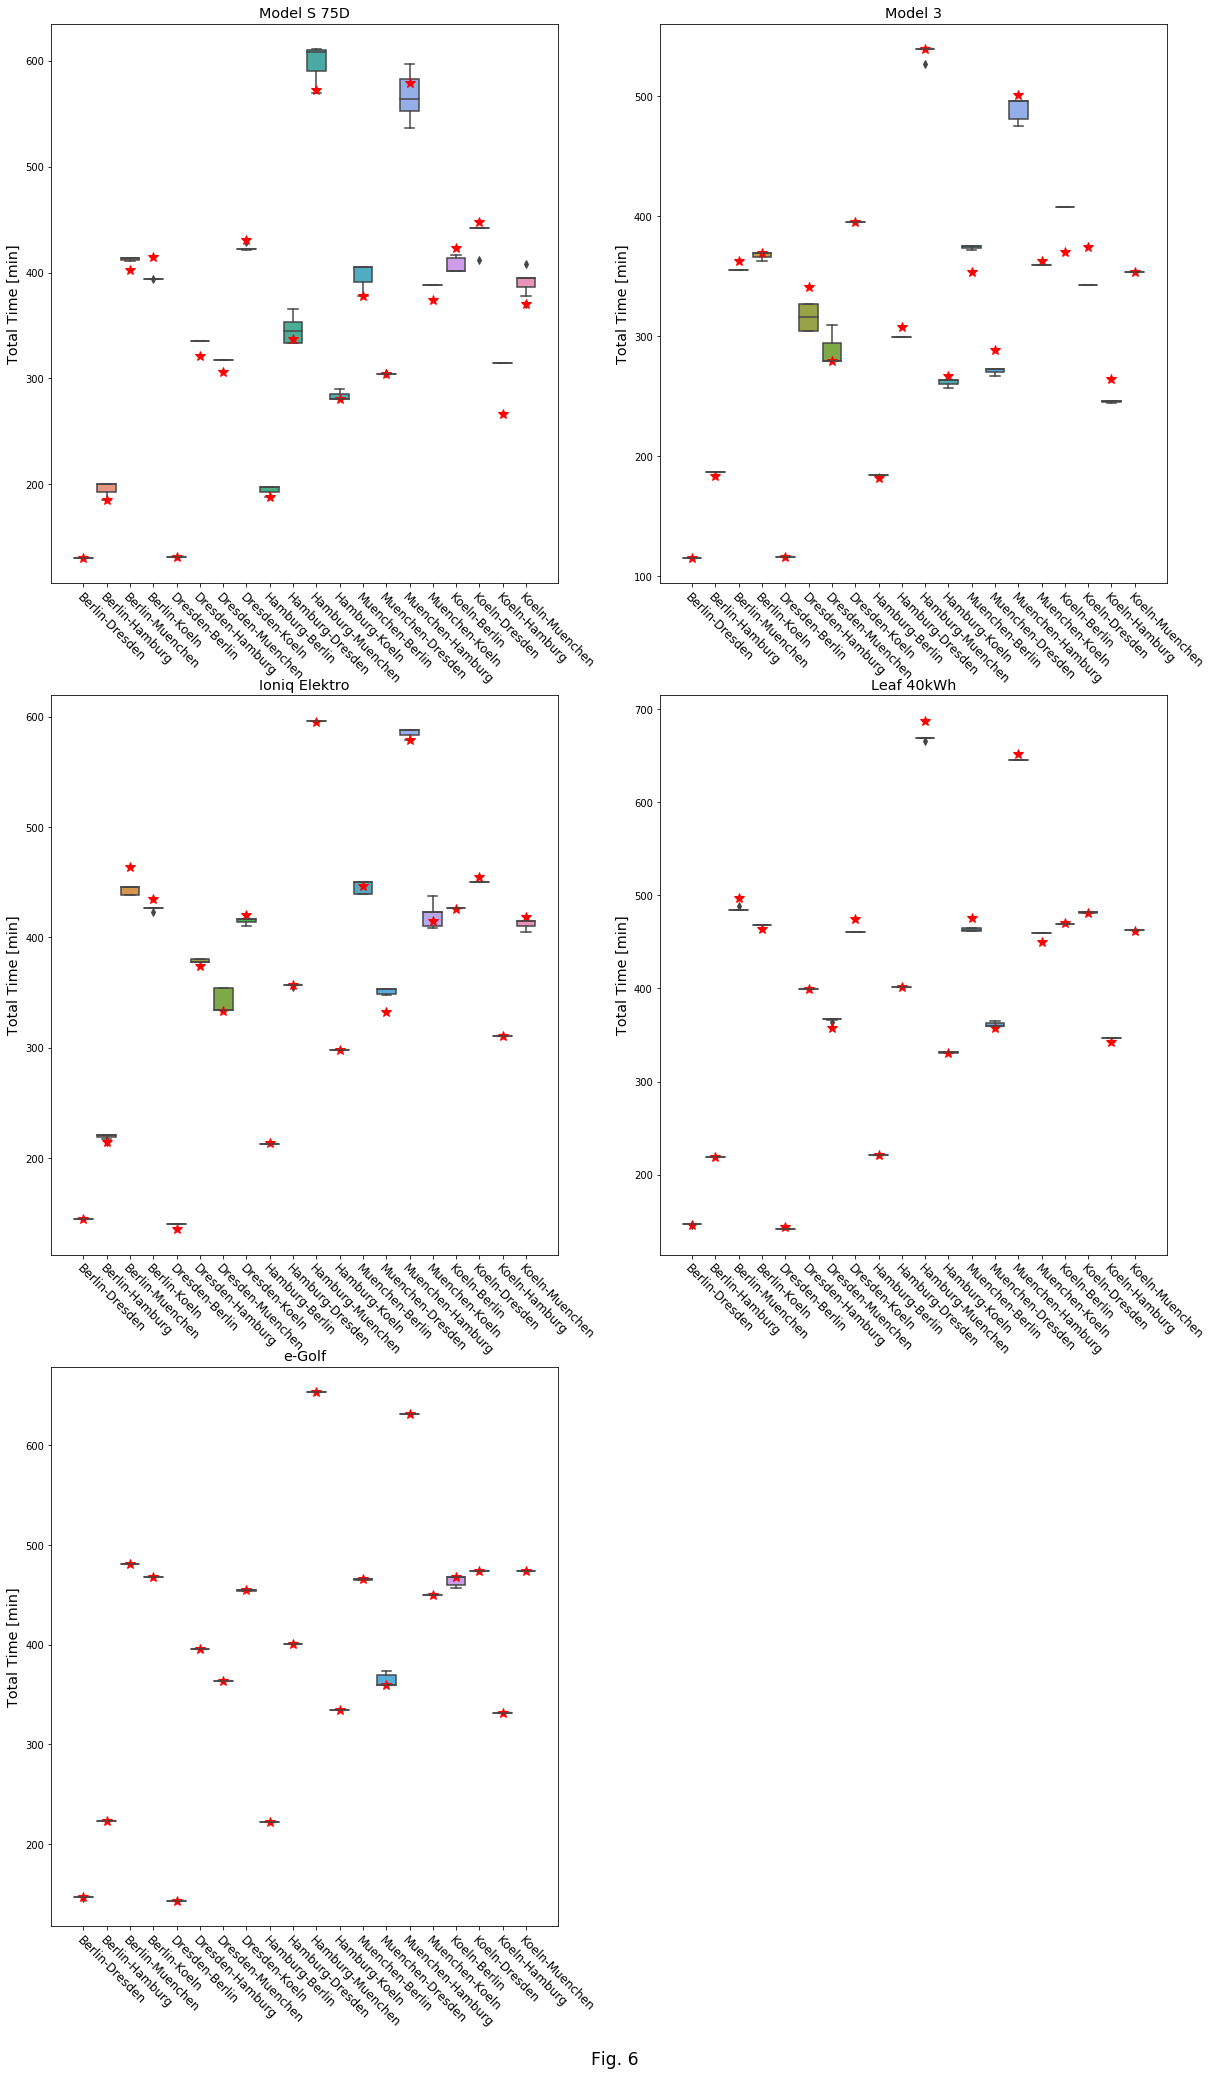

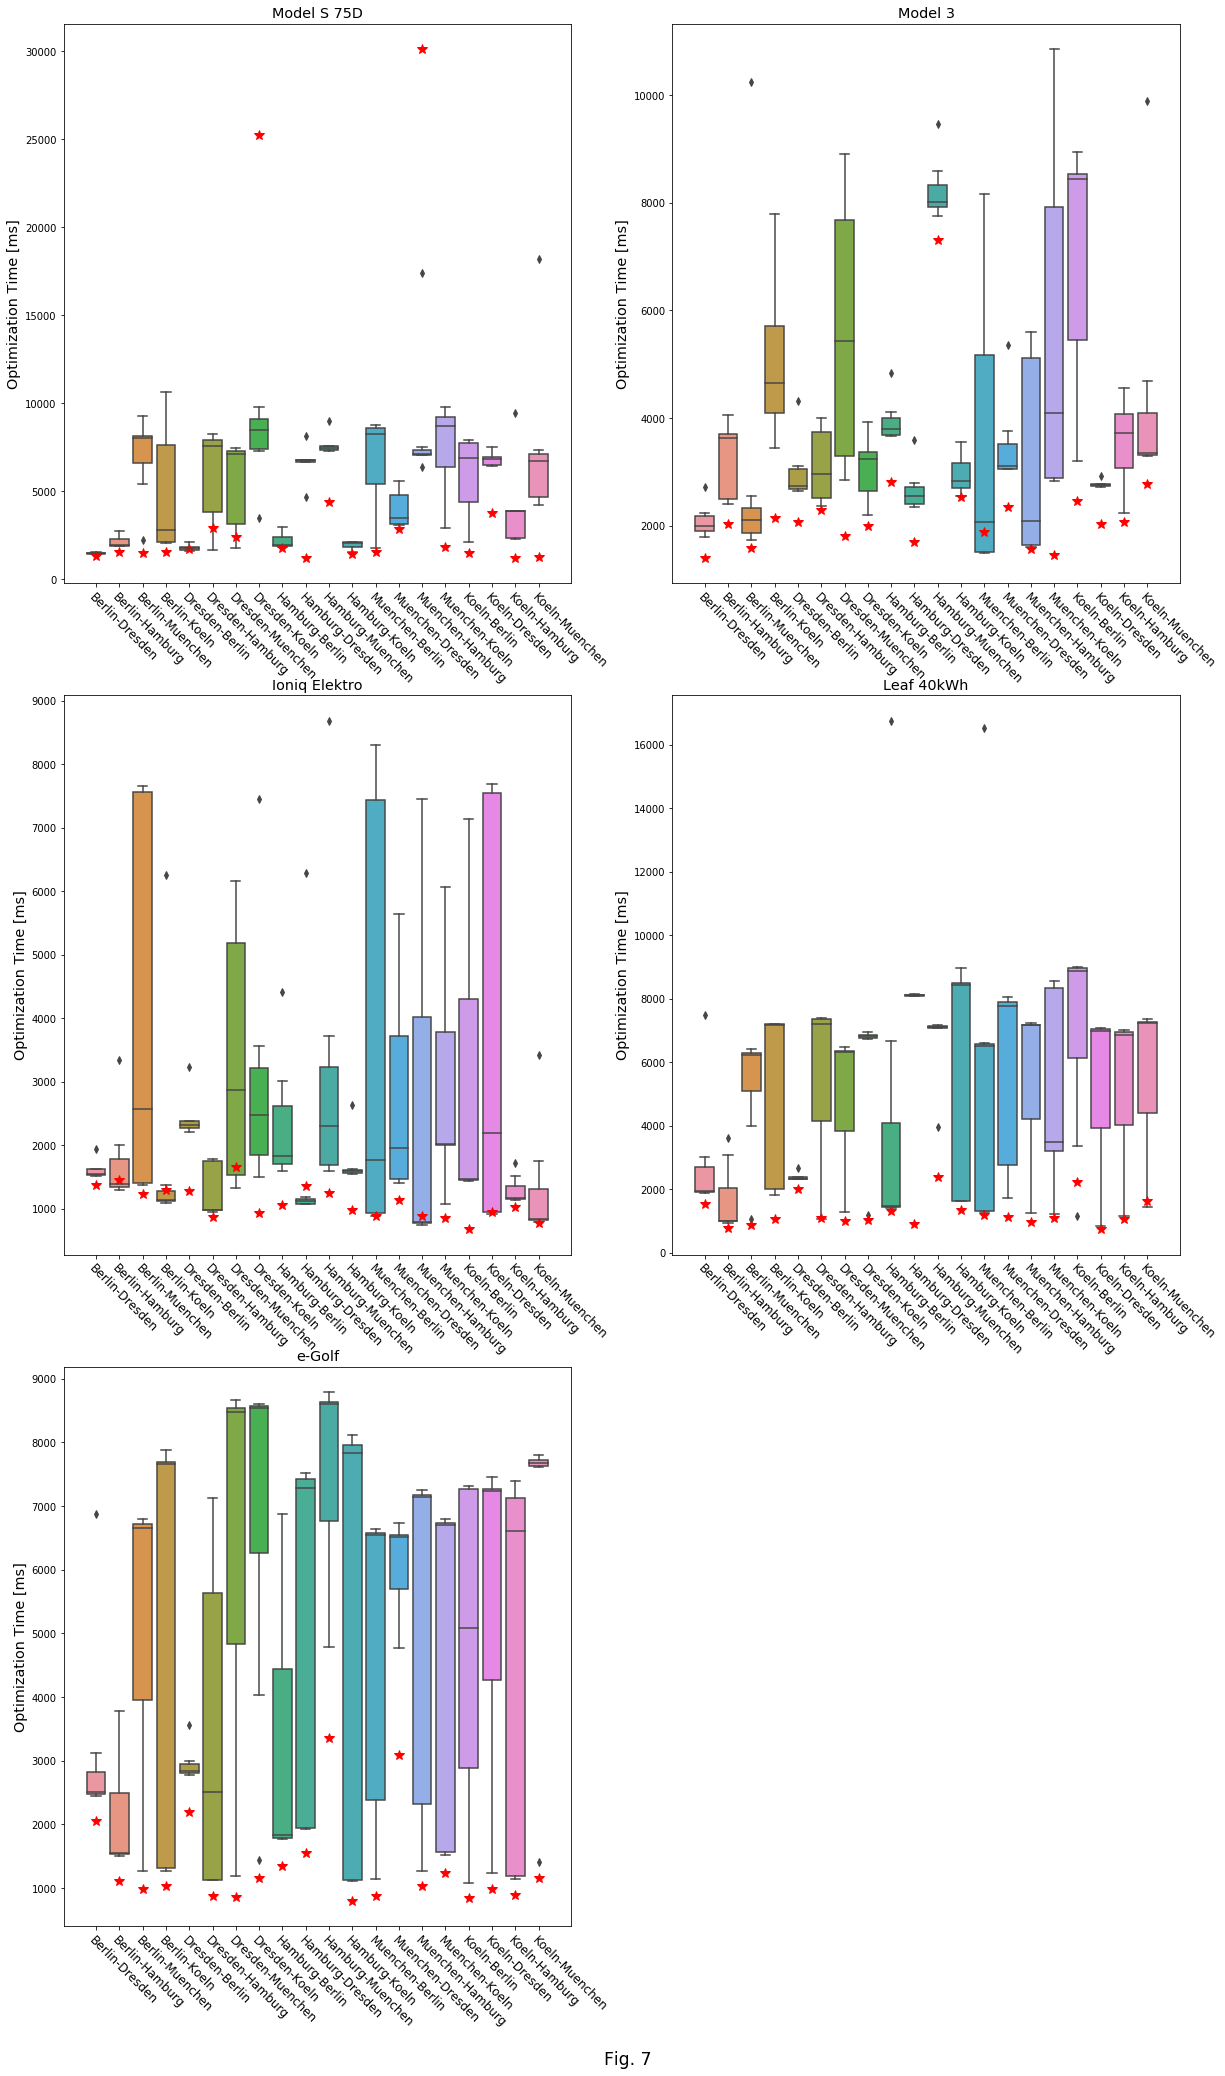

In [8]:
import seaborn as sns

def box_plots(my_y, label, fig_nr):
    fig = plt.figure(figsize=(20,35))
    data = oh_50_data
    for i, auto in enumerate(data.auto.unique()):
        ax1 = fig.add_subplot(3,2,i+1)
        masked = data[(data.auto==auto)]
        sns.boxplot(x='route', y=my_y, data=masked, ax=ax1)   
        masked = gap02_data[(gap02_data.auto==auto) & (gap02_data.overhead==50)]
        ax1.plot(masked.route,masked[my_y], '*', c='r', markersize=10 )
        plt.xticks(rotation=-45, rotation_mode="anchor",ha='left', fontsize='large')
    #    plt.legend([],[], frameon=False)
        plt.ylabel(label, fontsize='x-large')
        plt.xlabel('', fontsize='x-large')
        plt.title(auto,fontsize='x-large')
    fig.text(0.5,0.07,fig_nr, fontsize='xx-large')
    fig.tight_layout

box_plots('total_time', 'Total Time [min]', 'Fig. 6')
box_plots('wall time', 'Optimization Time [ms]', 'Fig. 7')

From the figures above, we can see that there is not much improvement when using multi-threading, specially regarding the optimization time which is much better using single threading (see Fig. 7). Just to finalize, let us estimate how many times was the calculated route data using multi-threading better than the single threading.

In [9]:
def comp(df1, df2):
    comp_data = pd.DataFrame()

    for auto in df1.auto.unique():
        for route in df1.route.unique():
            mask = (df1.route == route) & (df1.auto==auto)
            mask2 = (df2.route == route) & (df2.auto==auto)
            masked = df1[mask].copy()
            masked['charge_time'] = masked.charge_time.apply(lambda x: 1 if x < df2[mask2].charge_time.iloc[0] else 0)
            masked['drive_time'] =  masked.drive_time.apply(lambda x: 1 if x < df2[mask2].drive_time.iloc[0] else 0)
            masked['total_time'] =  masked.total_time.apply(lambda x: 1 if x < df2[mask2].total_time.iloc[0] else 0)
            masked['wall time'] =  masked['wall time'].apply(lambda x: 1 if x < df2[mask2]['wall time'].iloc[0] else 0)
            comp_data = comp_data.append(masked, ignore_index=False)

    grouped = comp_data[['auto', 'route', 'charge_time', 
                'drive_time', 'total_time','wall time', 'overhead']].groupby([ 'overhead']).sum().apply(lambda x : x/len(df1)*100)

    grouped=grouped.reset_index(drop=True)
    return grouped.round(2)

oh_50_singlethread = gap02_data[(gap02_data.overhead==50)]
_ = comp(oh_50_data, oh_50_singlethread).append(comp(oh_50_60s_data, oh_50_singlethread))
_.index =pd.Index(['30', '60'], name='Time limit [sec]')
print('Table 3: Times times Multi-threading was better than single threading in %')
_

Table 3: Times times Multi-threading was better than single threading in %


charge_time  drive_time  total_time  wall time
Time limit [sec]                                                
30                      23.93       46.42       32.81       7.74
60                      25.93       46.70       34.53       4.15

Table 3 shows the statistics of how many times the multi-threading solution yielded a better solution than that using single-threading in percent, for routes calculated using  30 and 60 seconds time limit. As depicted in Table 3, the total time was only about 32-35% of the time better with multi-threading. Charge time was only about 24% of the times better. But perhaps most important, we see the optimization time (wall time) was only 4 to 7% better. Hence, we can conclude that multi-threading does not enhance the performance of our algorithm, not in time, not in the quality of the resulting routes.

## Conclusion

In this report we have calculated about 8000 routes with different combination of electric vehicles, routes and algorithm parameters. By carefully comparing the obtained route results, we have observed that the best combination of parameters are an overhead value of 50 and a gap limit of 0.2. This set of parameters yield in average better results. For instance, the average optimization time is of 2 seconds, the amount of charging stops is moderate and their charging times are better (shorter) as compared to other combination of parameters. Furthermore, we have tested if by using multi-threading we obtained a performance enhancement, however, this was not the case.  